In [18]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import subprocess
import sys
sys.path.append('../..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

from IRSMicroLensing import IRSCaustics as IRSC
from IRSMicroLensing import IRSFunctions as IRSF

import VBMicrolensing
from skimage.draw import line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Initializing VBMicrolensing

In [19]:
VBM = VBMicrolensing.VBMicrolensing()

# Set relative accuracy
VBM.RelTol = 1e-03

# Set accuracy
VBM.Tol=1e-03

#### Defining reader function to read in IRSCaustic objects from file

In [20]:
def caustic_reader(file_path: str) -> IRSC.IRSCaustics:
    with open(file_path, 'rb') as f:
        return pickle.load(f)

#### Reading in single lens and triple lens objects

In [22]:
single_lens = caustic_reader('../Simulations/single_lens_1e11.pkl')
single_lens_CM = caustic_reader('../Simulations/single_lens_1e11_cm.pkl')
single_lens_cusp = caustic_reader('../Simulations/single_lens_1e11_cusp.pkl')
triple_lens = caustic_reader('../Simulations/triple_lens_1e11.pkl')

ang_width = single_lens.ang_width
pixels = single_lens.pixels
ang_res = single_lens.ang_res

print(f'Number of rays: {single_lens.num_rays:.4e}')
print(f'Number of rays: {triple_lens.num_rays:.4e}')

Number of rays: 1.5192e+11
Number of rays: 1.5192e+11


#### Viewing magnification maps

Plotting magnification map: 0.05 seconds
Plotting magnification map: 0.026 seconds
Plotting magnification map: 0.023 seconds
Plotting magnification map: 0.022 seconds


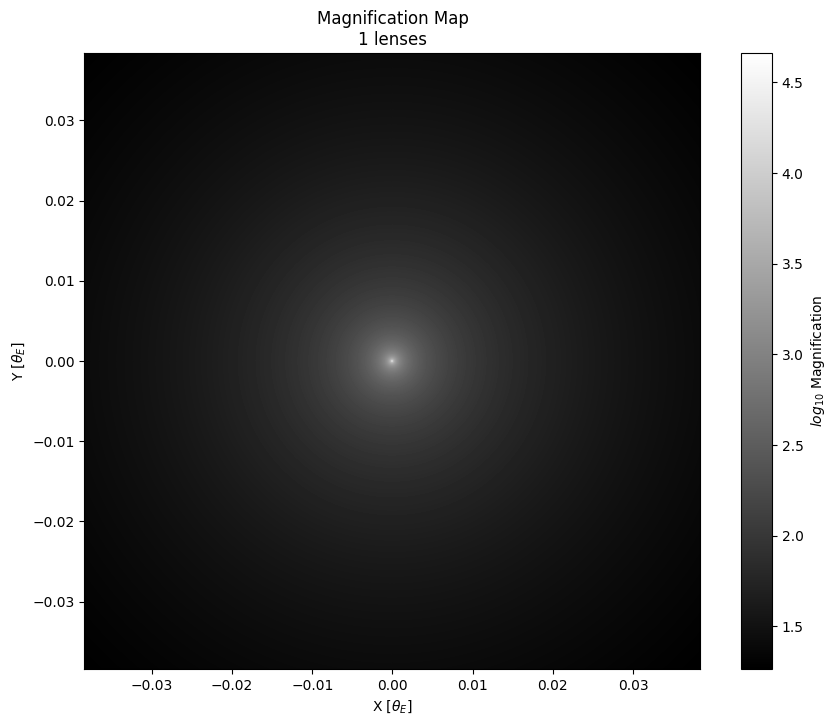

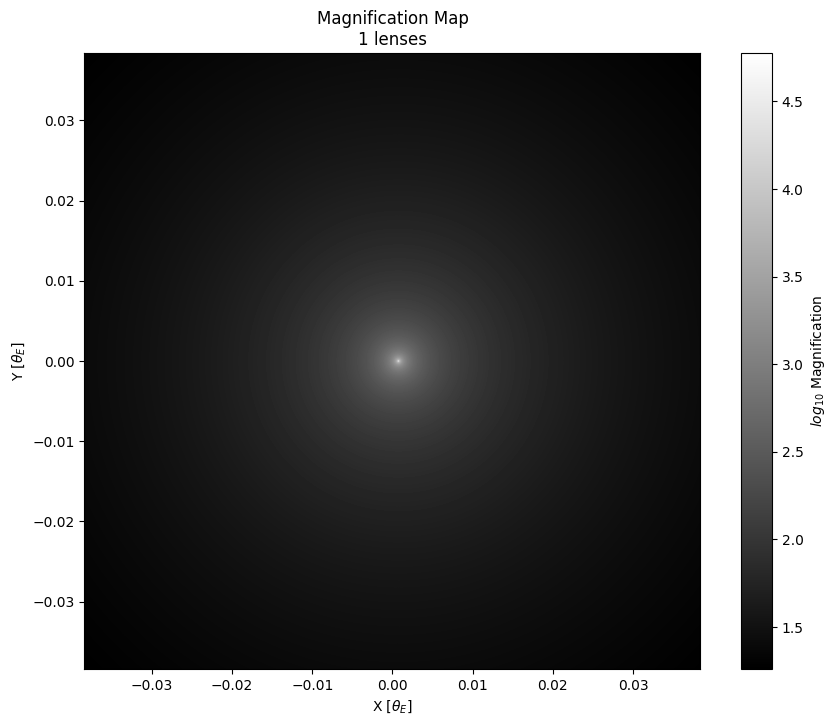

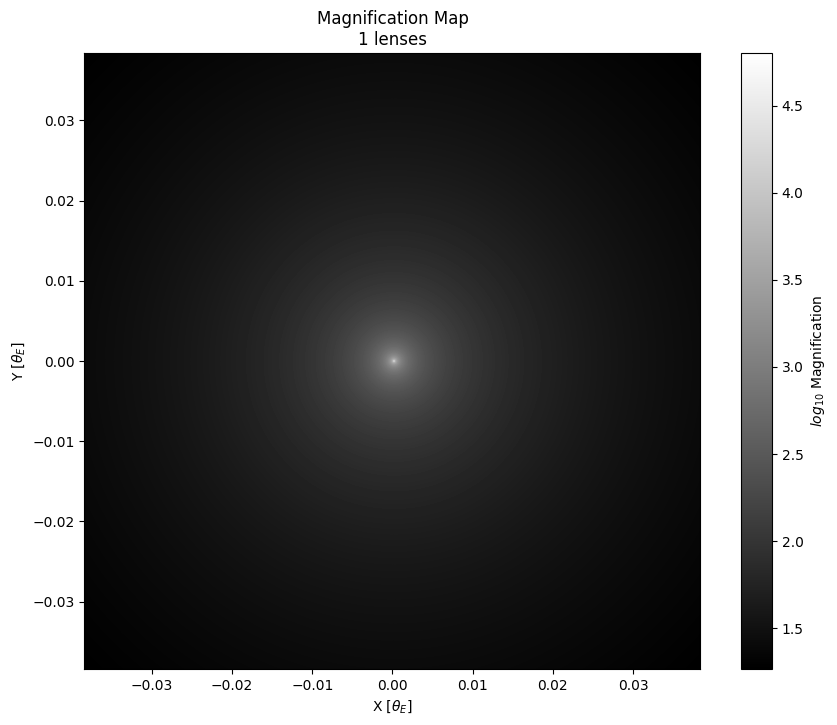

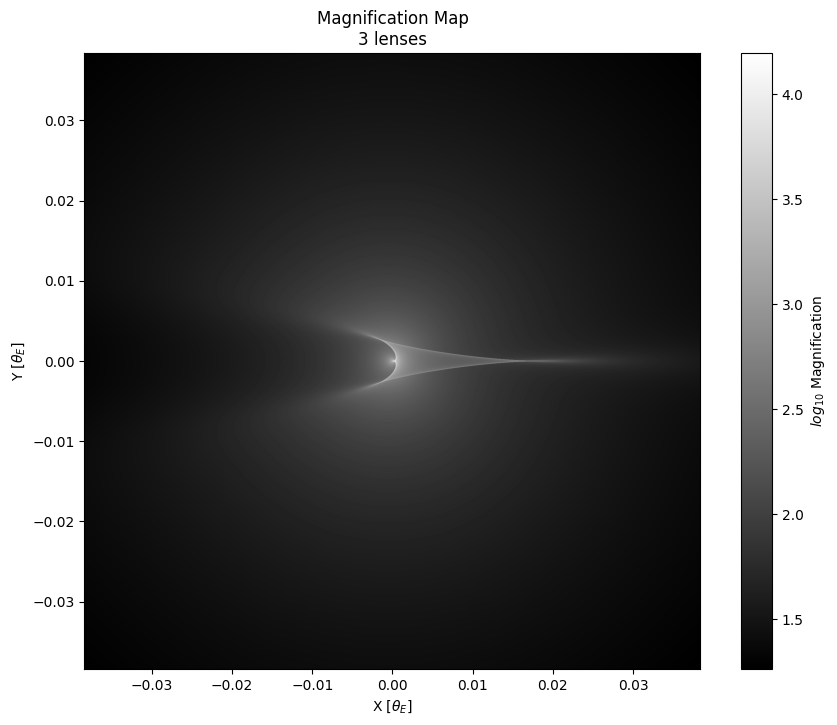

In [23]:
single_lens.plot()
single_lens_CM.plot()
single_lens_cusp.plot()
triple_lens.plot()

plt.show()

#### Defining source profile

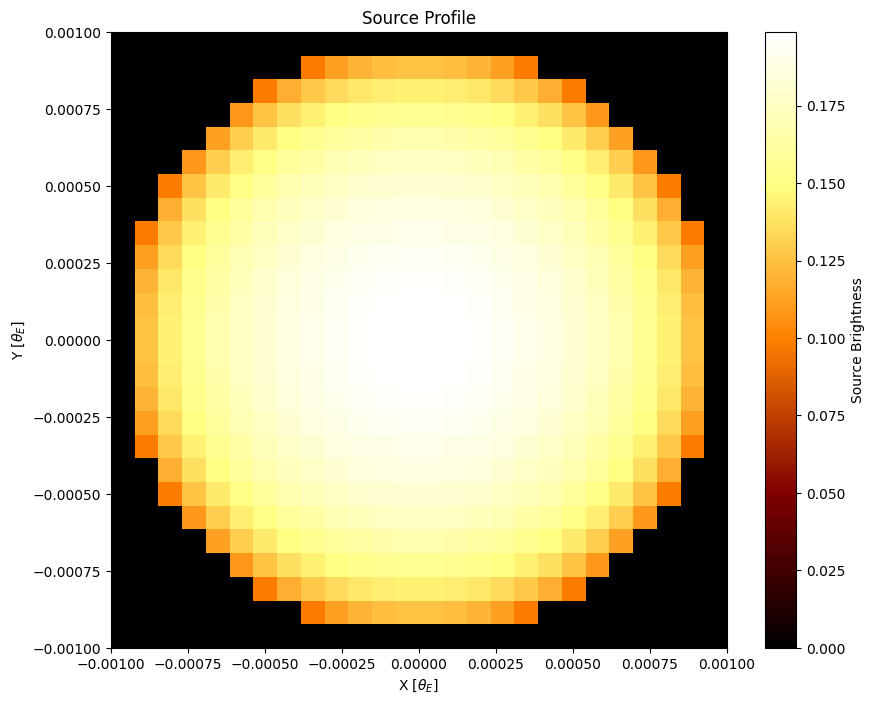

In [24]:
radius = 1e-3
LD = 0.5

source_profile = IRSF.IRSFunctions.source_profile(ang_res=single_lens.param_dict['ang_res'], rad=radius, profile_type='LD', LD=LD)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.imshow(source_profile, cmap='afmhot', extent=[-radius, radius, -radius, radius])
plt.colorbar(img, ax=ax, label='Source Brightness')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')
ax.set_title('Source Profile')

ax.set_aspect('equal')

plt.show()

#### Convolving source profile with both single lens and triple lens magnification maps

Convolving source profile with magnification map: 0.142 seconds
Convolving source profile with magnification map: 0.103 seconds
Convolving source profile with magnification map: 0.107 seconds
Convolving source profile with magnification map: 0.155 seconds


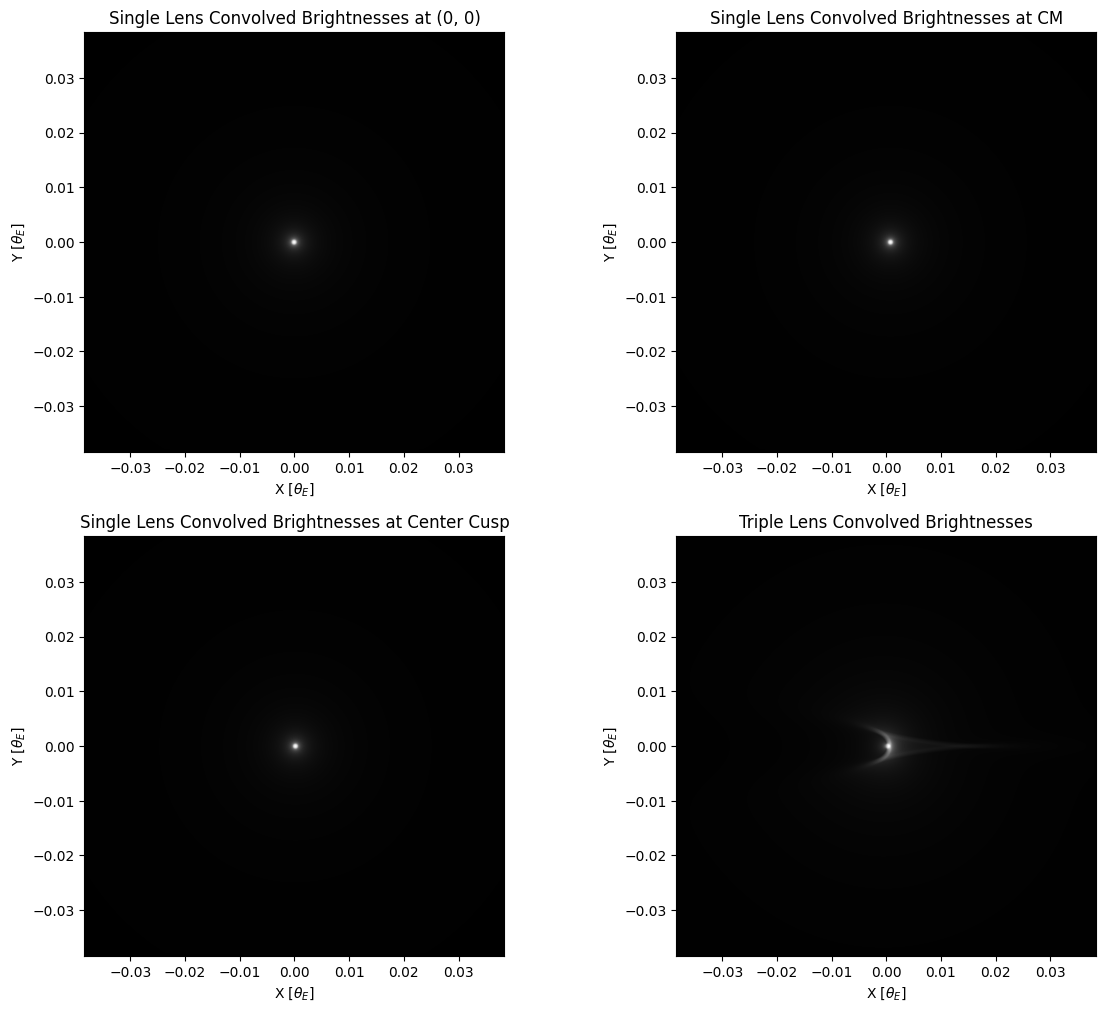

In [25]:
convolved_single_lens = single_lens.convolve(source_profile=source_profile)
convolved_single_lens_CM = single_lens_CM.convolve(source_profile=source_profile)
convolved_single_lens_cusp = single_lens_cusp.convolve(source_profile=source_profile)
convolved_triple_lens = triple_lens.convolve(source_profile=source_profile)

fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.imshow(convolved_single_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])
ax2.imshow(convolved_single_lens_CM, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])
ax3.imshow(convolved_single_lens_cusp, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])
ax4.imshow(convolved_triple_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])

ax1.set_xlabel('X [$\\theta_E$]')
ax1.set_ylabel('Y [$\\theta_E$]')
ax1.set_title('Single Lens Convolved Brightnesses at (0, 0)')
ax1.set_aspect('equal')

ax2.set_xlabel('X [$\\theta_E$]')
ax2.set_ylabel('Y [$\\theta_E$]')
ax2.set_title('Single Lens Convolved Brightnesses at CM')
ax2.set_aspect('equal')

ax3.set_xlabel('X [$\\theta_E$]')
ax3.set_ylabel('Y [$\\theta_E$]')
ax3.set_title('Single Lens Convolved Brightnesses at Center Cusp')
ax3.set_aspect('equal')

ax4.set_xlabel('X [$\\theta_E$]')
ax4.set_ylabel('Y [$\\theta_E$]')
ax4.set_title('Triple Lens Convolved Brightnesses')
ax4.set_aspect('equal')

plt.show()

#### Function to find all caustic points

In [26]:
def find_cusp_points(caustic_points):
    points = caustic_points.T  # Shape: (400, 2)

    vectors = np.diff(points, axis=0)  # Shape: (399, 2)

    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    unit_vectors = vectors / norms

    dot_products = np.sum(unit_vectors[:-1] * unit_vectors[1:], axis=1)
    dot_products = np.clip(dot_products, -1.0, 1.0)  # Clip to avoid numerical errors
    angles = np.rad2deg(np.arccos(dot_products))  # In degrees

    cusp_indices = np.where(angles > 50)[0] + 1  # +1 to shift to the index of the corner point

    return caustic_points[0, cusp_indices], caustic_points[1, cusp_indices]

#### Calculating and Plotting VBMicrolensing caustics

0.0002470252450260668 1.3212232075066055e-07


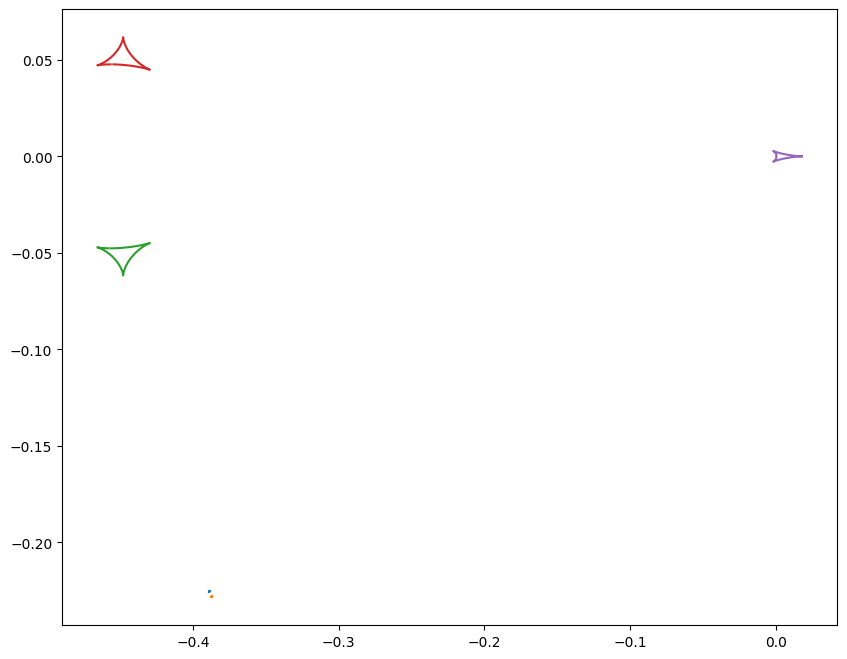

In [27]:
parameters = [item for sublist in triple_lens.lens_att for idx, item in enumerate(sublist) if idx != 2]
VBM.SetLensGeometry(parameters)

caustic_points = VBM.Multicaustics()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

all_cusp_xs = []
all_cusp_ys = []

for points in caustic_points:
    ax.plot(points[0], points[1])
    xs, ys = find_cusp_points(np.array(points))
    all_cusp_xs.append(xs)
    all_cusp_ys.append(ys)

all_cusp_xs = np.array(all_cusp_xs)
all_cusp_ys = np.array(all_cusp_ys)

all_cusp_distances = np.sqrt(all_cusp_xs**2 + all_cusp_ys**2)
min_indices = np.unravel_index(np.argmin(all_cusp_distances), all_cusp_distances.shape)

print(all_cusp_xs[min_indices], all_cusp_ys[min_indices])

plt.show()

#### Plotting deviation contours

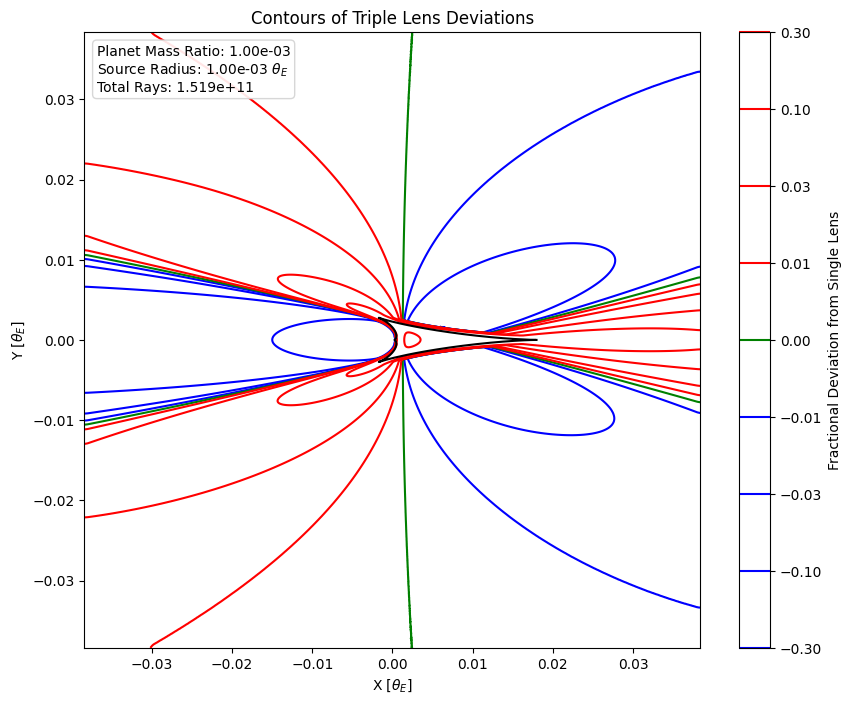

In [28]:
fractional_deviations = (convolved_triple_lens - convolved_single_lens) / convolved_single_lens

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# img = ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='grey')

img = plt.contour(single_lens.X_pix, single_lens.Y_pix, fractional_deviations,
                   levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                   colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red']
)

bar = plt.colorbar(img)
bar.set_label('Fractional Deviation from Single Lens')

ax.plot(caustic_points[min_indices[0]][0], caustic_points[min_indices[0]][1], color='black')

ax.set_title(f'Contours of Triple Lens Deviations')
ax.set_aspect('equal')
ax.set_xlim(-ang_width/2, ang_width/2)
ax.set_ylim(-ang_width/2, ang_width/2)

props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.9)
ax.text(0.02, 0.98, f'Planet Mass Ratio: {(triple_lens.lens_att[2][3] / triple_lens.lens_att[1][3]):.2e}\nSource Radius: {radius:.2e} $\\theta_E$\nTotal Rays: {(single_lens.num_rays):.3e}', va='top', zorder=10, bbox=props, transform=ax.transAxes, color='black')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')

# fig.savefig('Contours_Accurate.png', dpi=500)

plt.show()

#### Plotting multiple deviation contours

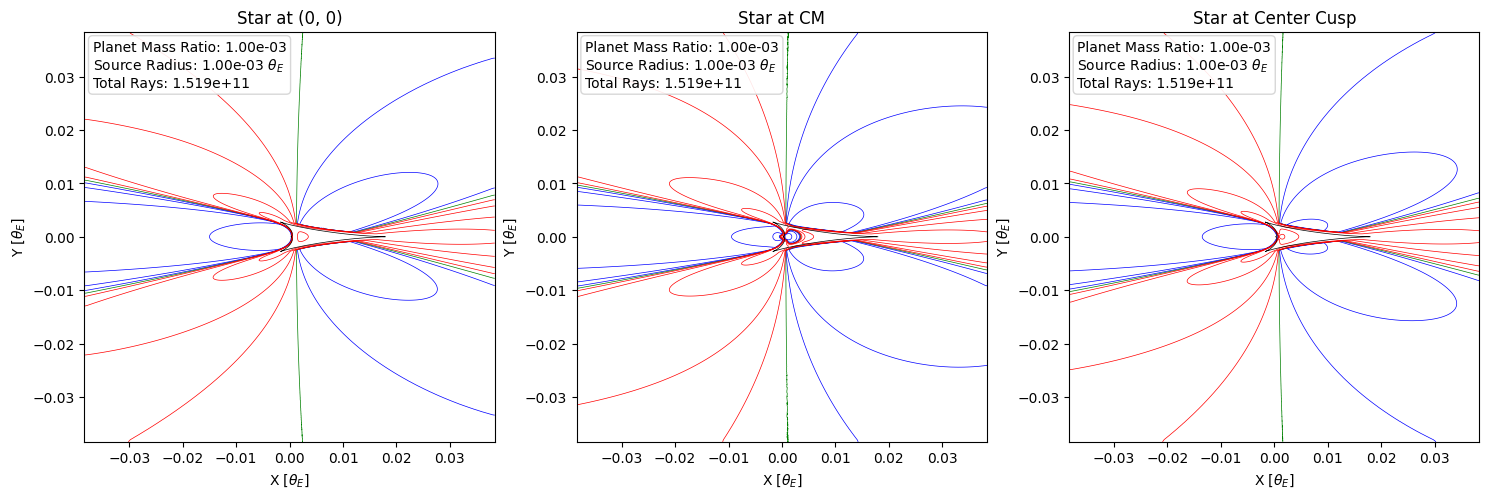

In [33]:
fractional_deviations = (convolved_triple_lens - convolved_single_lens) / convolved_single_lens
fractional_deviations_CM = (convolved_triple_lens - convolved_single_lens_CM) / convolved_single_lens_CM
fractional_deviations_cusp = (convolved_triple_lens - convolved_single_lens_cusp) / convolved_single_lens_cusp

fig = plt.figure(figsize=(18, 6))
axes = fig.subplots(1, 3)

# img = ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='grey')

for i, ax in enumerate(axes):
    if i == 0:
        brightnesses = fractional_deviations
        ax.set_title(f'Star at (0, 0)')
    elif i == 1:
        brightnesses = fractional_deviations_CM
        ax.set_title(f'Star at CM')
    elif i == 2:
        brightnesses = fractional_deviations_cusp
        ax.set_title(f'Star at Center Cusp')

    img = ax.contour(single_lens.X_pix, single_lens.Y_pix, brightnesses,
                    levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                    colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red'],
                    linewidths=0.5
    )

    # bar = plt.colorbar(img)
    # bar.set_label('Fractional Deviation from Single Lens')

    ax.plot(caustic_points[min_indices[0]][0], caustic_points[min_indices[0]][1], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.set_xlim(-ang_width/2, ang_width/2)
    ax.set_ylim(-ang_width/2, ang_width/2)

    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.9)
    ax.text(0.02, 0.98, f'Planet Mass Ratio: {(triple_lens.lens_att[2][3] / triple_lens.lens_att[1][3]):.2e}\nSource Radius: {radius:.2e} $\\theta_E$\nTotal Rays: {(single_lens.num_rays):.3e}', va='top', zorder=10, bbox=props, transform=ax.transAxes, color='black')

    ax.set_xlabel('X [$\\theta_E$]')
    ax.set_ylabel('Y [$\\theta_E$]')

fig.savefig('Contours_Triple.png', dpi=500)

plt.show()

#### Plotting lightcurves

/Users/saividyud/Documents/GitHub/NBLens/Unity/Analysis 6-4/../../IRSMicroLensing/IRSCaustics.py:1212: RuntimeWarning: divide by zero encountered in scalar divide
  t = (y_edge - y0) / dy


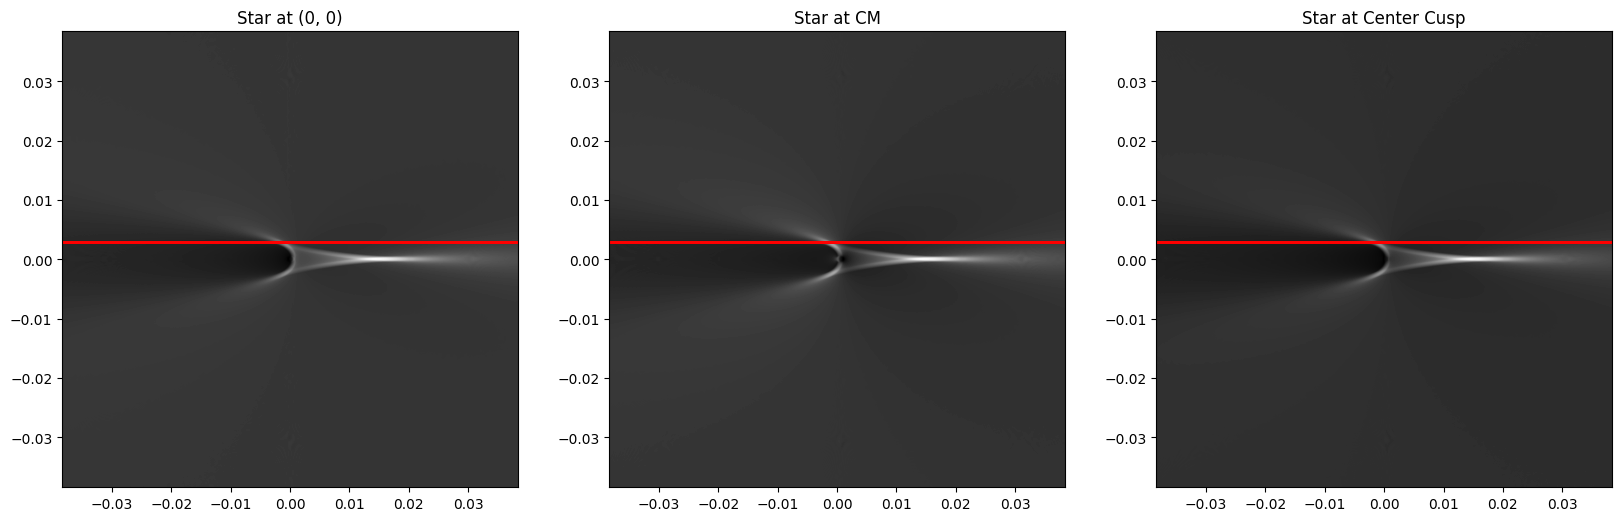

In [13]:
# Impact parameter
u = 0.003

# Angle from x axis
alpha = 0

fig = plt.figure(figsize=(20, 10))
axes = fig.subplots(1, 3)

line_values = []

for i, ax in enumerate(axes):
    if i == 0:
        brightnesses = fractional_deviations
        ax.set_title(f'Star at (0, 0)')
    elif i == 1:
        brightnesses = fractional_deviations_CM
        ax.set_title(f'Star at CM')
    elif i == 2:
        brightnesses = fractional_deviations_cusp
        ax.set_title(f'Star at Center Cusp')

    intersections, (xs, ys), times, vals = IRSC.IRSCaustics.lightcurve_calculator(u, alpha, ang_width, brightnesses)

    line_values.append(vals)

    ax.imshow(brightnesses, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='gray')
    ax.scatter(xs, ys, s=1, color='red')

plt.show()

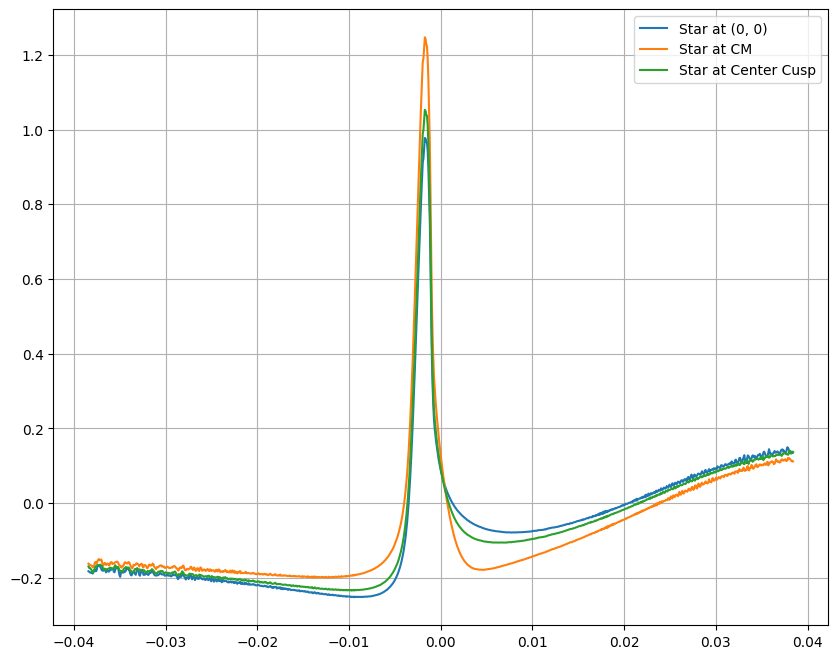

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

axes_lines = []

for i, line in enumerate(line_values):
    if i == 0:
        label = 'Star at (0, 0)'
    elif i == 1:
        label = 'Star at CM'
    elif i == 2:
        label = 'Star at Center Cusp'

    axes_lines.append(ax.plot(times, line, label=label))

ax.legend()
ax.grid(True)

plt.show()